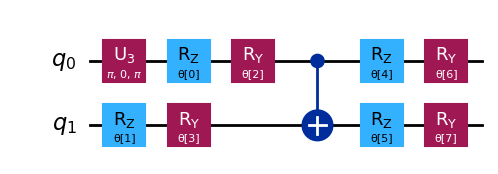

In [6]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable=SparsePauliOp.from_list([("ZZ", 1), ("IX", -2)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

In [7]:
def cost_func_vqe(parameters, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
    estimator_result = estimator_job.result()[0]

    cost = estimator_result.data.evs[0]
    return cost

In [8]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

In [9]:
# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA")

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.236067851482593
       x: [ 9.530e-01  1.107e+00  2.903e+00  3.140e+00  2.235e+00
            2.232e+00  1.169e+00  5.072e-01]
    nfev: 659
   maxcv: 0.0

In [5]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, Options
from qiskit_ibm_runtime import QiskitRuntimeService

token = "*******************************"
service = QiskitRuntimeService(channel='ibm_quantum', token=token)
backend = service.least_busy(operational=True, simulator=False)

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_ansatz = pm.run(ansatz)
isa_observable = observable.apply_layout(layout = isa_ansatz.layout)

In [17]:
x0 = np.ones(8)

with Session(backend=backend) as session:
    # session_options = Options()
    # session_options.execution.shots = 4096
    # session_options.resilience_level = 1

    estimator = Estimator()
    estimator.options.resilience_level = 1
    # sampler = Sampler(session = session)
    estimator.options.default_shots = 10000
    
    result = minimize(cost_func_vqe, x0, args=(isa_ansatz, isa_observable, estimator), method="COBYLA")

session.close()
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.266228831022211
       x: [ 1.926e+00  1.041e+00  3.024e+00  3.141e+00  2.179e+00
            2.318e+00  1.201e+00  4.170e-01]
    nfev: 82
   maxcv: 0.0


In [18]:
import numpy as np

def cost_func_ssvqe(params, initialized_anastz_list, weights, ansatz, hamiltonian, estimator):
    # """Return estimate of energy from estimator

    # Parameters:
    #     params (ndarray): Array of ansatz parameters
    #     initialized_anastz_list (list QuantumCircuit): Array of initialised ansatz with reference
    #     weights (list): List of weights
    #     ansatz (QuantumCircuit): Parameterized ansatz circuit
    #     hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
    #     estimator (Estimator): Estimator primitive instance

    # Returns:
    #     float: Weighted energy estimate
    # """

    energies = []

    # Define SSVQE

    weighted_energy_sum = np.dot(energies, weights)
    return weighted_energy_sum

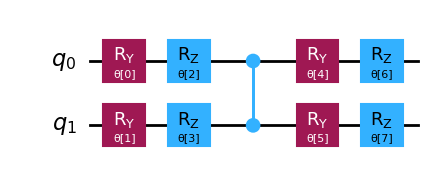

In [19]:
from qiskit.circuit.library import TwoLocal

raw_ansatz = TwoLocal(2, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps=1)

raw_ansatz.decompose().draw('mpl')

In [20]:
import numpy as np

def calculate_overlaps(ansatz, prev_circuits, parameters, sampler):

    def create_fidelity_circuit(circuit_1, circuit_2):

        """
        Constructs the list of fidelity circuits to be evaluated.
        These circuits represent the state overlap between pairs of input circuits,
        and their construction depends on the fidelity method implementations.
        """
                
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit
    overlaps = []

    for prev_circuit in prev_circuits:
        fidelity_circuit = create_fidelity_circuit(ansatz, prev_circuit)
        sampler_job = sampler.run([(fidelity_circuit, parameters)])
        meas_data = sampler_job.result()[0].data.meas
        
        counts_0 = meas_data.get_int_counts().get(0, 0)
        shots = meas_data.num_shots
        overlap = counts_0/shots
        overlaps.append(overlap)
    
    return np.array(overlaps)

In [21]:
def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian):

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])

    total_cost = 0

    if step > 1:
        overlaps = calculate_overlaps(ansatz, prev_states, parameters, sampler)
        total_cost = np.sum([np.real(betas[state] * overlap) for state, overlap in enumerate(overlaps)])

    estimator_result = estimator_job.result()[0]

    value = estimator_result.data.evs[0] + total_cost

    return value

In [25]:
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.primitives import StatevectorEstimator as Estimator
sampler = Sampler()
estimator = Estimator()

In [26]:
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp.from_list([("ZZ", 1), ("IX", -2)])

In [27]:
k = 3
betas = [33, 33, 33]
x0 = np.zeros(8)

In [28]:
from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable), method="COBYLA", options={'maxiter': 200,})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -2.2360653320860147
       x: [-8.746e-04  1.364e-01  2.996e-01  1.523e+00  5.143e-03
           -4.290e-04 -1.407e+00 -1.589e+00]
    nfev: 200
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.8734689041712242
       x: [-1.056e-02  2.013e-01  3.018e-01 -7.052e-01 -3.770e-01
            7.814e-02 -1.332e+00 -6.462e-01]
    nfev: 136
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 2.1050347095648085
       x: [ 1.944e+00  1.523e-01  4.856e-01  1.389e+00  4.129e-01
            8.078e-01  1.381e+00  1.146e-01]
    nfev: 92
   maxcv: 0.0
